In [0]:
import torch
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import logging
import numpy as np
import random
import time

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Link to google drive and download data

from google.colab import drive
drive.mount('/content/gdrive/')


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
# Define the Net


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(28, 64, (5,5), padding = 2)
        self.conv1_bn = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, 2, padding = 2)

        self.fc1 = nn.Linear(2048, 1024)

        self.dropout = nn.Dropout(0.3)

        self.fc2 = nn.Linear(1024, 512)

        self.bn = nn.BatchNorm1d(1)

        self.fc3 = nn.Linear(512, 128)

        self.fc4 = nn.Linear(128,47)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = self.conv1_bn(x)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)


        x = x.view(-1, 2048)
        x = F.relu(self.fc1(x))

        x = self.dropout(x)

        x = self.fc2(x)

        x = x.view(-1, 1, 512)
        x = self.bn(x)

        x = x.view(-1, 512)
        x = self.fc3(x)
        x = self.fc4(x)

        #return F.log_softmax(x, dim=1)
        
        return x

In [0]:
root = ''

#test data tranform
transform_valid = transforms.Compose(
    [
     transforms.ToTensor(),
     
    ])
emnist_test = datasets.EMNIST(root,split = 'balanced', train=False, download=True, transform = transform_valid)

In [7]:
# Download wights

!wget https://imadelhanafi.com/data/draft/cnn_weights_blog.pth

--2019-07-28 10:51:27--  https://imadelhanafi.com/data/draft/cnn_weights_blog.pth
Resolving imadelhanafi.com (imadelhanafi.com)... 104.28.28.48, 104.28.29.48, 2606:4700:30::681c:1d30, ...
Connecting to imadelhanafi.com (imadelhanafi.com)|104.28.28.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11093914 (11M) [application/octet-stream]
Saving to: ‘cnn_weights_blog.pth’

cnn_weights_blog.pt 100%[===================>]  10.58M  46.2MB/s    in 0.2s    

2019-07-28 10:51:28 (46.2 MB/s) - ‘cnn_weights_blog.pth’ saved [11093914/11093914]



Inference on GPU
G prediction
tensor([0.9985], device='cuda:0') probability
G real value


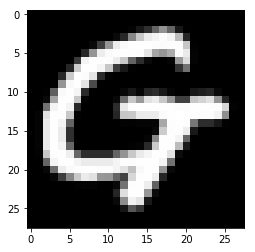

inference time on GPU:  0.17154407501220703


In [8]:
# Download weights

net = Net()

model_weights = 'cnn_weights_blog.pth'
net.load_state_dict(torch.load(model_weights)["state_dict"])
net.eval()

# Send to GPU

device = torch.device('cuda:0')
net.to(device)

random_img = 13

class_mapping = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'

print('Inference on GPU')
start = time.time()
with torch.no_grad():

  data = emnist_test.data[random_img] # (1,28,28)
  
  data = data.type(torch.FloatTensor)
  data = data/255
  
  data = data.view(1, 28, 28, 1).to(device)
  data = torch.transpose(data, 1, 2)
  
  out = net(data)
  probabilities = F.softmax(out, dim = 1)
  pred_y = torch.max(probabilities, 1)[1].cpu().data.numpy()
  
  print(class_mapping[int(pred_y)], 'prediction')
  print(torch.max(probabilities, 1)[0], 'probability')
  plt.imshow(data.cpu().reshape([28, 28]), cmap='Greys_r')
  print(class_mapping[int(emnist_test.targets[random_img].numpy())], 'real value')
  plt.show()

end = time.time()
print("inference time on GPU: ", end-start)